In [1]:
import warnings

In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np
from custom_library.custom_lib import *

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()

# Import data set:

In [ ]:
pd.options.mode.chained_assignment = None


df_full = import_dataset(encoding='utf-8')
# Convert json to csv:
# df_full.to_csv('../data/dk_asylum_data_1.csv', encoding='utf-8', index=False)
df_full.shape

(9359, 5)

# Dataset preprocessing:

Keep ALL cases except for Unknown Homeland (Ukendt hjemland):

In [ ]:
df_ALL = df_full[df_full.country != "Ukendt hjemland"]

# Drop redundant column:
df_ALL.drop('hasText', axis=1, inplace=True)

df = df_ALL

df["text"] = df["text"].astype("string")

df.shape

(9167, 4)

In [ ]:

df.head()

,id,asylum_motive,country,text
0,0,"[Generelle forhold, Privatretlig forhold, Æn...",Afghanistan,Nævnet stadfæstede i februar 2022 en g...
1,1,"[Sur Place, Helbredsmæssige forhold, Generel...",Afghanistan,Nævnet stadfæstede i februar 2022 en g...
2,2,"[Internal Flight Alternative, Generelle forho...",Afghanistan,ævnet meddelte i marts 2022 opholdstil...
3,3,"[Sur Place, Chikane, Generelle forhold, Øvr...",Afghanistan,Nævnet meddelte i februar 2022 opholds...
4,4,"[Sur Place, Chikane, Øvrige modsætningsforho...",Afghanistan,Nævnet meddelte i februar 2022 opholds...


Check for potential duplicates and drop them:

In [ ]:
duplicates_df = df[df.duplicated(['text'], keep='last')]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

,id,asylum_motive,country,text
69,69,"[Generelle forhold, Øvrige modsætningsforhold...",Syrien,Nævnet omgjorde i november 2021 Udlænd...
70,70,"[Generelle forhold, Øvrige modsætningsforhold...",Syrien,Nævnet omgjorde i november 2021 Udlænd...
457,457,"[Udsendelse (§ 49 a m.v.), Sur Place, Privat...",Afghanistan,Nævnet stadfæstede i juli 2021 Udlændi...
697,697,"[Første asylland/§29 b, Generelle forhold]",Italien,Nævnet stadfæstede i februar 2021 Udlæ...
701,701,"[Inddragelse/forlængelse, Militære forhold, ...",Syrien,Nævnet omgjorde i marts 2021 Udlænding...
...,...,...,...,...
9128,9128,"[Politiske forhold, Agents of Persecution, T...",Afghanistan,Nævnet meddelte i juli 2010 opholdstilladelse ...
9309,9309,[Politiske forhold],Afghanistan,Nævnet stadfæstede i juni 2005 Udlændi...
9320,9320,[Privatretlig forhold],Afghanistan,Nævnet stadfæstede i december 2005 Udl...
9328,9328,[Politiske forhold],Afghanistan,Nævnet stadfæstede i april 2004 en afg...


See shape of new data frame:

In [ ]:
# Drop duplicates from original dataframe based on text column
# If the summary is the same probalbly were are looking at a duplicate
# without taking into account all other variables(columns):
df = df.drop_duplicates('text', keep='last')
# Check shape again:
df.shape

(8689, 4)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [ ]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8689.0,4688.684313,2747.737234,0.0,2246.0,4724.0,7067.0,9358.0
length,8689.0,4166.397859,2186.312800,407.0,2664.0,3786.0,5161.0,22106.0


## Boxplot:

<AxesSubplot:>

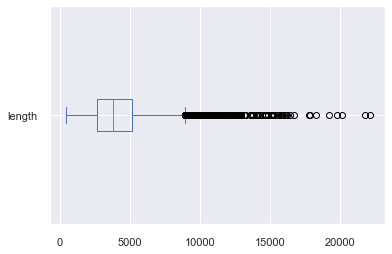

In [ ]:
# Box plot:
df['length'].plot(kind='box', vert=False)

# Text Processing:

Column `text` is processed in order to extract data concerning:
- decision outcome
- gender of applicants
- year of decision

Steps included in the pipeline:
- lower casing
- punctuation removal
- stopword removal
- single letter word removal
- tokenization
- lemmatization

In [ ]:
pipeline = [str.lower, remove_punctuation, remove_stopwords, drop_single_letter_words,
            tokenize, lemmatize]

In [ ]:
# Apply the process:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

See ten first entries

In [ ]:
df.head(10)

,id,asylum_motive,country,text,length,tokens,num_tokens
0,0,"[Generelle forhold, Privatretlig forhold, Æn...",Afghanistan,Nævnet stadfæstede i februar 2022 en g...,9055,"[stadfæste, 2022, genoptage, spontan, asylsag,...",741
1,1,"[Sur Place, Helbredsmæssige forhold, Generel...",Afghanistan,Nævnet stadfæstede i februar 2022 en g...,13640,"[stadfæste, 2022, genoptage, spontan, asylsag,...",1099
2,2,"[Internal Flight Alternative, Generelle forho...",Afghanistan,ævnet meddelte i marts 2022 opholdstil...,3326,"[meddele, 2022, opholdstilladelse, kbstatus, m...",233
3,3,"[Sur Place, Chikane, Generelle forhold, Øvr...",Afghanistan,Nævnet meddelte i februar 2022 opholds...,2130,"[meddele, 2022, opholdstilladelse, kstatus, kv...",152
4,4,"[Sur Place, Chikane, Øvrige modsætningsforho...",Afghanistan,Nævnet meddelte i februar 2022 opholds...,3019,"[meddele, 2022, opholdstilladelse, kstatus, ma...",213
5,5,"[Udsendelse (§ 49 a m.v.), Religiøse forhold,...",Afghanistan,Nævnet stadfæstede i marts 2022 Udlænd...,10041,"[stadfæste, 2022, udlændingestyrels, afgørelse...",830
6,6,"[Mindreårige, Generelle forhold, Øvrige mods...",Afghanistan,Nævnet stadfæstede i marts 2022 Udlænd...,8615,"[stadfæste, 2022, udlændingestyrels, afgørelse...",726
7,7,"[Generelle forhold, Helbredsmæssige forhold, ...",Afghanistan,Nævnet meddelte i april 2022 opholdsti...,4368,"[meddele, 2022, opholdstilladelse, bstatus, kv...",305
8,8,"[Sur Place, Etniske forhold, Uforholdsmæssig...",Afghanistan,Nævnet stadfæstede i april 2022 Udlænd...,16424,"[stadfæste, 2022, udlændingestyrels, afgørelse...",1379
9,9,"[Etniske forhold, Generelle forhold, Ændrede...",Afghanistan,Nævnet stadfæstede i februar 2022 Udlæ...,15065,"[stadfæste, 2022, udlændingestyrels, afgørelse...",1274
